### Temporal Transformers Trainer
This notebook Builds the Temporal Transformer Model as the main Dynamic Gestures Classifier

In [6]:
import numpy as np
import os
import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import layers

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Concatenate Batch Files

In [2]:
def concatenate_files_from_folders(folder_paths):
    arrays = []
    for folder_path in folder_paths:
        # List all .npy files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.npy'):
                file_path = os.path.join(folder_path, file_name)
                # Load the .npy file and append it to the list
                arrays.append(np.load(file_path))
    
    # Concatenate all arrays along the first axis
    concatenated_data = np.concatenate(arrays, axis=0)
    np.random.shuffle(concatenated_data)
    return concatenated_data

In [3]:
folder_1 = 'Dataset/Batch1/seq_skeleton'
folder_2 = 'Dataset/Batch1/seq_skeleton'

In [4]:
data = concatenate_files_from_folders([folder_1, folder_2])

#### Extract Data and Do Train Test Split

In [5]:
#extracting data
x_data = data[:, :, :-1]
labels = data[:, 0, -1]
y_data = labels
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)
#train test splot
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2024)

In [15]:
x_train.shape

(229761, 65, 99)

#### Define Temporal Transformer

In [7]:
input_shape = (65,99)
n_classes = 14
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


#### Build Transformer Model
We scale our transformer model by specifying the transformer blocks cascaded and mlp units per block

In [18]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()
keras.utils.plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True, dpi=100)
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 65, 99)]             0         []                            
                                                                                                  
 multi_head_attention_9 (Mu  (None, 65, 99)               408675    ['input_6[0][0]',             
 ltiHeadAttention)                                                   'input_6[0][0]']             
                                                                                                  
 dropout_23 (Dropout)        (None, 65, 99)               0         ['multi_head_attention_9[0][0]
                                                                    ']                            
                                                                                            

#### Train

In [19]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=15,
    callbacks=[
        ModelCheckpoint("Trained Models/dynamic/1_temporal_transformer_quad_stack.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.5, patience=10, verbose=1, mode='auto')
    ]
)


Epoch 1/15
7180/7181 [============================>.] - ETA: 0s - loss: 1.6080 - sparse_categorical_accuracy: 0.7543
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.88437, saving model to Trained Models/dynamic\1_temporal_transformer_quad_stack.h5
7181/7181 [==============================] - 712s 99ms/step - loss: 1.6080 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.3341 - val_sparse_categorical_accuracy: 0.8844 - lr: 1.0000e-04
Epoch 2/15


c:\Users\Christian\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7180/7181 [============================>.] - ETA: 0s - loss: 0.3720 - sparse_categorical_accuracy: 0.8690
Epoch 2: val_sparse_categorical_accuracy improved from 0.88437 to 0.90626, saving model to Trained Models/dynamic\1_temporal_transformer_quad_stack.h5
7181/7181 [==============================] - 687s 96ms/step - loss: 0.3720 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.2555 - val_sparse_categorical_accuracy: 0.9063 - lr: 1.0000e-04
Epoch 3/15
7180/7181 [============================>.] - ETA: 0s - loss: 0.2871 - sparse_categorical_accuracy: 0.8960
Epoch 3: val_sparse_categorical_accuracy improved from 0.90626 to 0.91704, saving model to Trained Models/dynamic\1_temporal_transformer_quad_stack.h5
7181/7181 [==============================] - 703s 98ms/step - loss: 0.2871 - sparse_categorical_accuracy: 0.8960 - val_loss: 0.2194 - val_sparse_categorical_accuracy: 0.9170 - lr: 1.0000e-04
Epoch 4/15
7180/7181 [============================>.] - ETA: 0s - loss: 0.2525 - sparse_categ

### Plot Train History

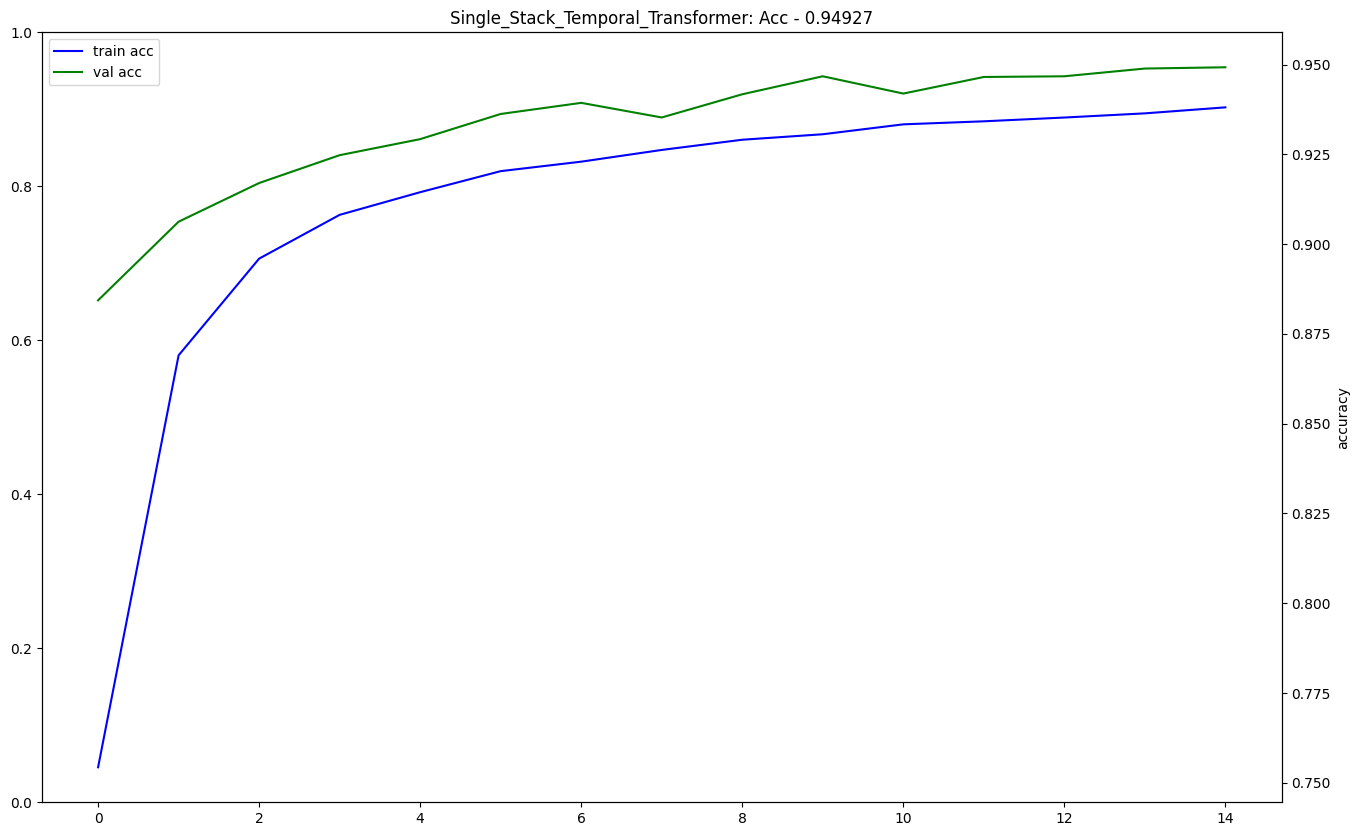

In [28]:
#printing results
import matplotlib.pyplot as plt
%matplotlib inline

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['sparse_categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_sparse_categorical_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.title('Single_Stack_Temporal_Transformer: Acc - 0.94927')

plt.show()

798/798 [==============================] - 29s 36ms/step


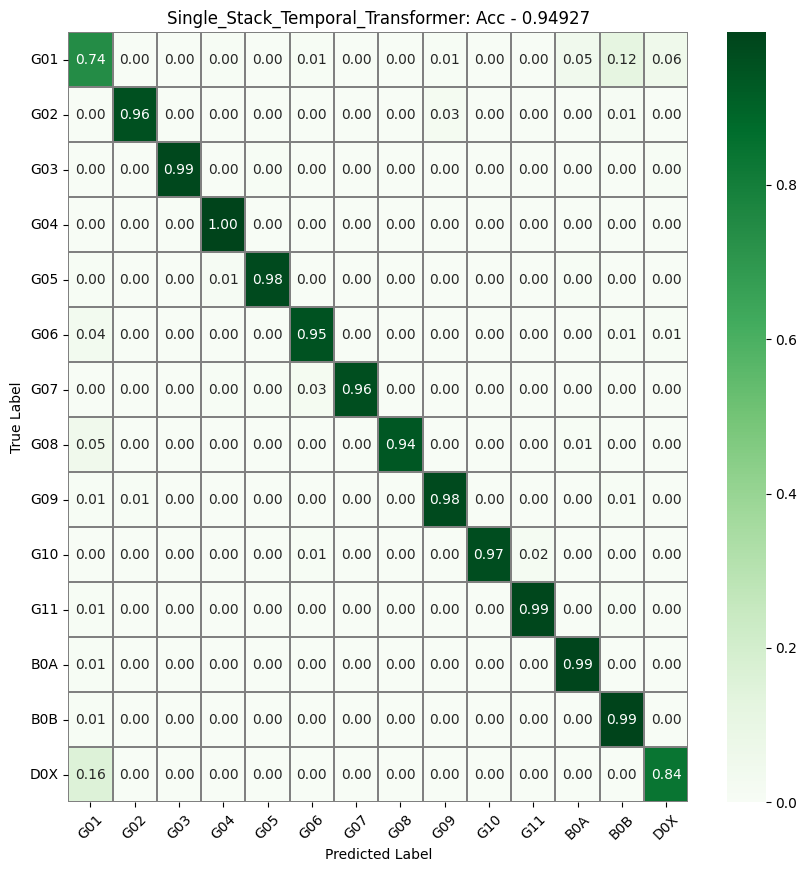

<Figure size 640x480 with 0 Axes>

In [34]:
import seaborn as sns
from sklearn import metrics


# Define the actions (class names)
actions = ['G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'B0A', 'B0B', 'D0X']

# Predict the classes
Y_pred = model.predict(x_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = y_val

# Compute the confusion matrix
confusion_mtx = metrics.confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(10, 10))  # Adjusted the size for better readability
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.2f', 
            xticklabels=actions, yticklabels=actions, ax=ax)

# Set axis labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Single_Stack_Temporal_Transformer: Acc - 0.94927')
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.yticks(rotation=0)

# Show the plot
plt.show()
plt.savefig('Figures/Single_Stack_Temporal_Transformer_0.94927.jpg')
